In [585]:
!pip install -r requirements.txt


[notice] A new release of pip available: 22.3 -> 24.1.2
[notice] To update, run: pip3 install --upgrade pip
Reshimming asdf python...


In [480]:
import crop_sim
import importlib
importlib.reload(crop_sim)

<module 'crop_sim' from '/Users/theron/code/crop-models/crop_sim.py'>

     ZIP  latitude  longitude
0  33483   26.4546   -80.0656


In [609]:
# crop_sim.generate_near()

In [612]:
%matplotlib widget

# Select your crop of interest (replace 'Maize' with your desired crop)
crop_name = 'Allium cepa' #onion
# crop_name= "Lycopersicon esculentum" # Tomatoes
# crop_name = "Brassica juncea" # Mustard greens
# crop_name = "Vigna unguiculata"
# crop_name = "Ipomoea batatas" # sweet potato
# crop_name = "Solanum tuberosum" # Potato
bolting = False
frost_tolerance = 0


# short day: 11-12, long=14;16
min_day = 10
max_day = 12
crop_sim.all_in_one("33483", crop_name, bolting, min_day, max_day)

In [645]:
# crop_sim.plot_suitability(view_window, growing_season_suitability, daily_suitability, lat, lon, crop_name, cutoff)

In [631]:
# suit = growing_season_suitability[view_window]
# x = suit.where(suit > 0)
# y = xr.where(suit > 0, suit, 0)
# x == y
# print(suit)

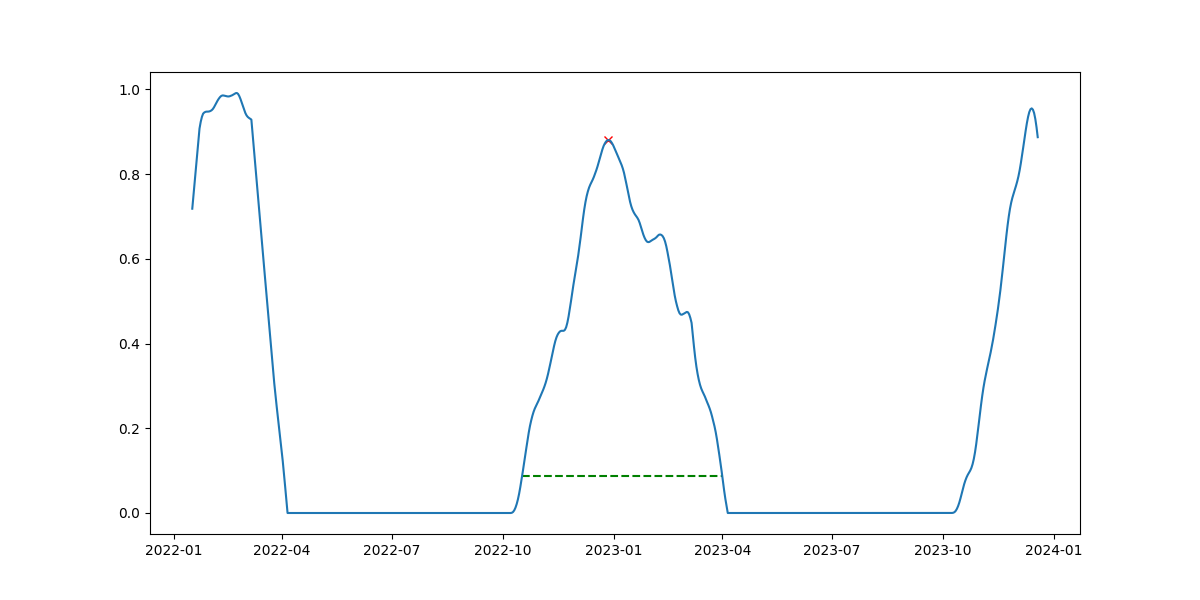

In [642]:
plt.subplots(figsize=(12, 6))

# plt.plot(suit.time, .isel(lat=lat,lon=lon), color="green")
plt.plot(suit.time, suit.isel(lat=lat,lon=lon))
# from scipy.signal import savgol_filter
# # Apply Savitzky-Golay filter
# window_length = 13  # Must be odd
# polyorder = 3

# smoothed_data = xr.apply_ufunc(
#     savgol_filter,
#     suit,
#     kwargs={"window_length": window_length, "polyorder": polyorder},
#     input_core_dims=[["time"]],
#     output_core_dims=[["time"]],  # Output is a single value per input
#     output_dtypes=[suit.dtype]
# )
# plt.plot(smoothed_data.isel(lat=lat,lon=lon))
plt.show()

In [643]:
print(crop_sim.merge_overlapping_monthday_ranges(plant_ranges))

[(10, 17, 12, 16)]


In [532]:
growing_season_suitability[view_window].isel(lat=lat,lon=lon).quantile(0.2)

<xarray.DataArray ()> Size: 8B
array(0.)
Coordinates:
    quantile  float64 8B 0.2

In [631]:
# import pandas as pd
# import xarray as xr
# tasmin = loca_tasmin.isel(lon=lon,lat=lat)
# # frost_days = pd.Series(tasmin < 273.15).rolling(window=7, min_periods=1).sum().to_numpy()
# frost_days = (tasmin < 273.15)

# # nippy_days = pd.Series(((tasmin < tmin + 273.15) & (tasmin > 273.15)).astype(int)).rolling(window=7, min_periods=1).sum().to_numpy()
# groups = frost_days.cumsum()
# group_sizes = groups.groupby(groups).count()
# max_consecutive_frost_days = 1
# extended_frost_mask = xr.ones_like(groups, dtype=bool)
# for group_number, size in group_sizes.to_pandas().items():  # Convert to Pandas for easier iteration
#     if size > max_consecutive_frost_days:
#         extended_frost_mask = xr.where(groups == group_number, False, extended_frost_mask)



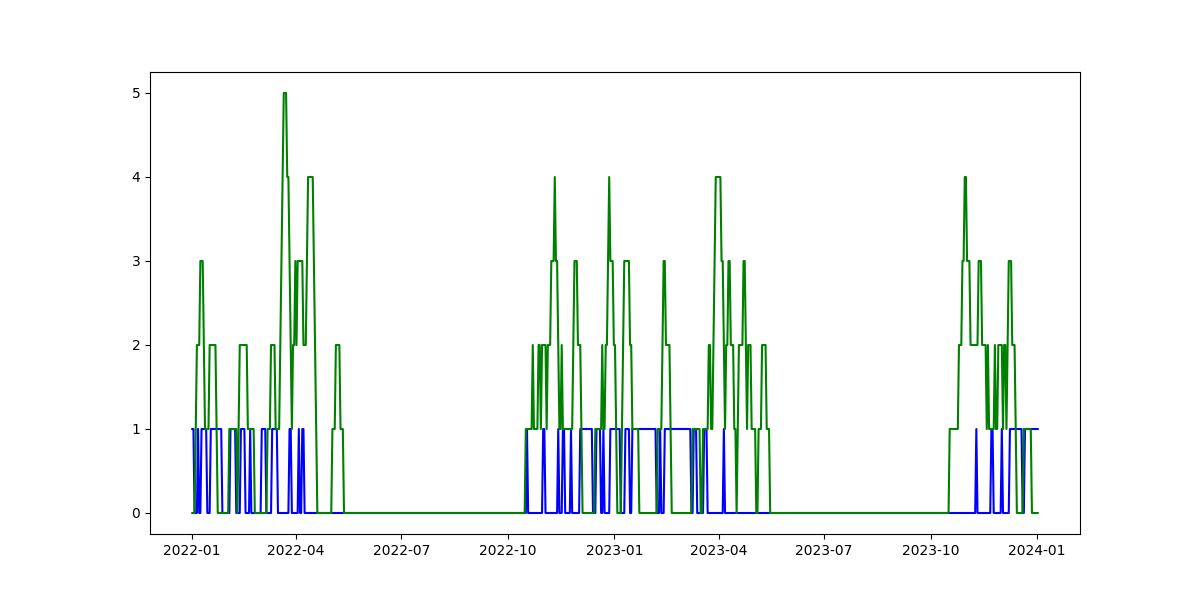

In [634]:
# import matplotlib.pyplot as plt
# fig, ax1 = plt.subplots(figsize=(12, 6))
# ax1.plot(tasmin.time, extended_frost_mask, linestyle='-', color='blue')
# ax1.plot(tasmin.time, nippy_days, linestyle='-', color='green')
# plt.show()